# Testing the accuracy of perturbative calculations
The simulator makes use of first-order perturbative calculations. The accuracy of these calculations is estimated through a comparison with exact calculations for small systems, for which an exact calculation is computationally feasible.

Here results are shown for a many-body Hamiltonian with random diagonal elements, nearest-neighbour hopping terms and diagonal perturbation. The strength of the hopping is defined by $t$. The strength of the perturbation is defined by $K$.

$H = \sum_i \epsilon_i a_i^\dagger a_i + t \left[a_i^\dagger a_{i+1} + a_{i+1}^\dagger a_i \right] + K a_i^\dagger a_i^\dagger a_i a_i$

The values $\epsilon_i$ are taken from a normal distribution with standard deviation $W$ and mean $w0$.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matrixensembles import BosonChainSampler, MatrixStats, BosonOHSampler
from studies import ManyBodyLevels
import itertools
from utils import bosonmatplot, errorhist, paramstring
from operators import BosonSystemSpec

## Small system
This is a simulation of a small system (4 sites, 2 particles). The eigenvalues and spacings can be inspected manually.

If $t=0$, the matrix is diagonal and the perturbative calculation is exact. Indeed, the numerical calculation reports exactly the same values as the perturbative one. For $t=1$ the estimates are not always close.

Here is reported the calculation for $t = 1$ and $K = 0.05$.

Description of the outputs:

 - Matrix of the many-body Hamiltonian in the two-particle basis (right column: Fock state corresponding to index)
 - Eigenvalues of the full Hamiltonian (exact).
 - Eigenvalue spacings (exact)
 - Eigenvalues of the unperturbed Hamiltonian.
 - Eigenvalues (first order perturbation theory)
 - Spacings (first order perturbation theory)

In [2]:
### Exact
n, e = 4, 2
K = 0.05
t = 1
W = 0.
sampler = BosonChainSampler(n, W, t, K=0, e=e)
sample = sampler.sample()
eigvals1 = np.linalg.eigvalsh(sample)

sampler = BosonChainSampler(n, W, t, K=K, e=e)
systemspec = BosonSystemSpec(n, e)
sample = sampler.sample()
bosonmatplot(systemspec, sample)
print(f"E with K=0: ", " ".join([f"{v:.4g}" for v in eigvals1]))
print()

### Perturbative
sampler = BosonChainSampler(n, W, t, e=1)
study = ManyBodyLevels(e, K)
matrixstats = MatrixStats(sampler)
matrixstats.collect(n_realizations=1, eigenvectors=True)
manybody = study(matrixstats)
print("perturbative E: ", " ".join([f"{v:.3f}" for v in manybody.eigenvalues().flatten()]))
print("perturbative S: ", " ".join([f"{v:.3f}" for v in manybody.spacings().flatten()]))

20.1 1.4 0.0 1.4 0.0 0.0 0.0 0.0 0.0 0.0  ;  2 0 0 0
1.4 20.0 1.0 0.0 1.4 0.0 1.0 0.0 0.0 0.0  ;  1 1 0 0
0.0 1.0 20.0 1.0 0.0 1.0 0.0 0.0 1.0 0.0  ;  1 0 1 0
1.4 0.0 1.0 20.0 0.0 0.0 1.0 0.0 0.0 1.4  ;  1 0 0 1
0.0 1.4 0.0 0.0 20.1 1.4 0.0 0.0 0.0 0.0  ;  0 2 0 0
0.0 0.0 1.0 0.0 1.4 20.0 1.0 1.4 0.0 0.0  ;  0 1 1 0
0.0 1.0 0.0 1.0 0.0 1.0 20.0 0.0 1.0 0.0  ;  0 1 0 1
0.0 0.0 0.0 0.0 0.0 1.4 0.0 20.1 1.4 0.0  ;  0 0 2 0
0.0 0.0 1.0 0.0 0.0 0.0 1.0 1.4 20.0 1.4  ;  0 0 1 1
0.0 0.0 0.0 1.4 0.0 0.0 0.0 0.0 1.4 20.1  ;  0 0 0 2

             E:  16.025 18.049 18.049 20.000 20.000 20.050 20.100 22.051 22.051 24.025
             S:  2.025 0.000 1.951 0.000 0.050 0.050 1.951 0.000 1.975 

E with K=0:  16 18 18 20 20 20 20 22 22 24



100%|██████████| 10/10 [00:00<00:00, 17520.07it/s]

perturbative E:  16.025 18.050 18.050 20.000 20.050 20.050 20.050 22.050 22.050 24.025
perturbative S:  2.025 0.000 1.950 0.050 0.000 0.000 2.000 0.000 1.975


## Manual verification

Let's consider the following system. Eigenvalues are calculated with the exact method, with the perturbative method, and with a direct calculation done "by hand" for 2 bosons.

The two perturbative calculations are in perfect agreement. The perturbative calculation is close to the exact one, but not enough to get correct spacings, as shown afterwards.

In [3]:
n, e = 4, 2
K = 0.1
t = 1
W = 0.5
# exact
rng = np.random.default_rng(seed=42)
sampler = BosonChainSampler(n, W, t, K=K, e=e, rng=rng)
sample = sampler.sample()
exact_eigenvalues = np.linalg.eigvalsh(sample)

# perturbative
rng = np.random.default_rng(seed=42)
sampler = BosonChainSampler(n, W, t, e=1, rng=rng)
study = ManyBodyLevels(e, K)
matrixstats = MatrixStats(sampler)
matrixstats.collect(n_realizations=1, eigenvectors=True)
manybody = study(matrixstats)
eigenvalues = np.linalg.eigvalsh(sampler.sample())
print("exact eigenvalues:                 ", " ".join([f"{v:.3f}" for v in exact_eigenvalues]))
print("perturbative eigenvalues:          ", " ".join([f"{v:.3f}" for v in manybody.eigenvalues().flatten()]))

# calculate perturbation by hand
def pert_2(v1, v2):
	""" First order perturbation for two particles in states v1 and v2. """
	dE = 4*K*np.sum(np.abs(v1*v2)**2) / (1 + np.abs(np.sum(np.conj(v1)*v2))**2)
	return dE

evc = matrixstats.eigenvectors()
eva = matrixstats.eigenvalues()
pert_E = []
for i, j in itertools.combinations_with_replacement(range(n), 2):
	v1, v2 = evc[0, :, i], evc[0, :, j]
	pert_E.append(eva[0, i] + eva[0, j] + pert_2(v1, v2))

pert_E = np.sort(pert_E)
print("perturbative eigenvalues (by hand):", " ".join([f"{v:.3f}" for v in pert_E]))

100%|██████████| 10/10 [00:00<00:00, 16428.92it/s]

exact eigenvalues:                  16.142 18.139 18.392 20.053 20.264 20.318 20.642 22.272 22.552 24.417
perturbative eigenvalues:           16.144 18.141 18.395 20.066 20.270 20.311 20.629 22.269 22.549 24.416
perturbative eigenvalues (by hand): 16.144 18.141 18.395 20.066 20.270 20.311 20.629 22.269 22.549 24.416


## Comparison of 2-gap correlation statistic

The average ratio between adjacent spacings ($r$ scalar) is calculated with the exact method as well as the perturbative one. The perturbative method always produces a value of $r$ typical of Poisson-distributed eigenvalues.

In [4]:
### Exact
n, e = 10, 5
K = 0.1
W = 2
t = 1
sampler = BosonChainSampler(n, W, t, K=K, e=e, w0=100)
matrixstats = MatrixStats(sampler)
matrixstats.collect(n_realizations=20, eigenvectors=False)
print(f"r = {np.mean(matrixstats.d2correlations()):.2f}\n")

### Perturbative
sampler = BosonChainSampler(n, W, t, e=1, w0=100)
study = ManyBodyLevels(e, K)
matrixstats = MatrixStats(sampler)
matrixstats.collect(n_realizations=20, eigenvectors=True)
manybody = study(matrixstats)
print(f"r = {np.mean(manybody.d2correlations()):.2f}\n")

100%|██████████| 20/20 [00:07<00:00,  2.80it/s]


r = 0.42



100%|██████████| 2002/2002 [00:00<00:00, 7198.74it/s]

r = 0.39



### Dependency between errors on spacings and perturbation strength
A small system is considered and the spacings distribution is calculated with the exact method as well as the perturbative one. The two methods of calculation do not agree, as shown by the plots and by the "Area error" (the area of the difference between the two plots)

In [199]:
K = 0.05
W = 2
t = 1
### Exact
n, e = 10, 5
sampler = BosonChainSampler(n, W, t, K=K, e=e, w0=100)
matrixstats = MatrixStats(sampler)
matrixstats.collect(n_realizations=1000, eigenvectors=False)

### Perturbative
sampler = BosonChainSampler(n, W, t, e=1, w0=100)
study = ManyBodyLevels(e, K)
sstats = MatrixStats(sampler)
sstats.collect(n_realizations=1000, eigenvectors=True)
manybody = study(sstats)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 2002/2002 [00:11<00:00, 176.84it/s]


Area error: 6.3%


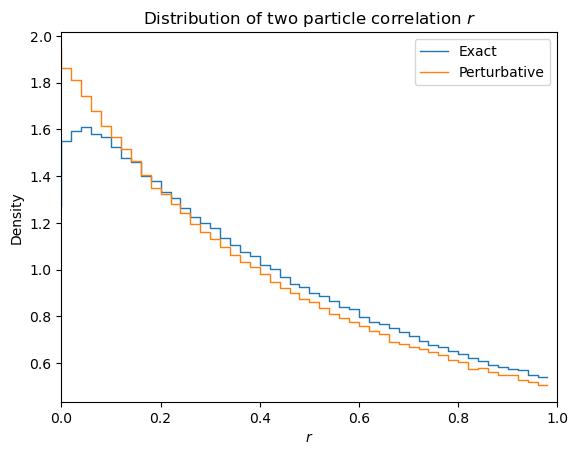

In [200]:
rg = (matrixstats.d2correlations().min(), matrixstats.d2correlations().max())
exact_hist, exact_edges = np.histogram(matrixstats.d2correlations(), bins=50, range=rg, density=True)
pert_hist, pert_edges = np.histogram(manybody.d2correlations(), bins=50, range=rg, density=True)
plt.step(exact_edges[:-1], exact_hist, label="Exact", where="pre")
plt.step(pert_edges[:-1], pert_hist, label="Perturbative", where="pre")
plt.xlim(0, 1.)
plt.legend()
plt.xlabel(r"$r$")
plt.ylabel(r"Density")
plt.title("Distribution of two particle correlation $r$")
error_percentage = np.sum(np.abs(exact_hist - pert_hist) * (exact_edges[1] - exact_edges[0]))
print(f"Area error: {error_percentage:.1%}")

### Effect of perturbation strength

100%|██████████| 1000/1000 [05:56<00:00,  2.80it/s]


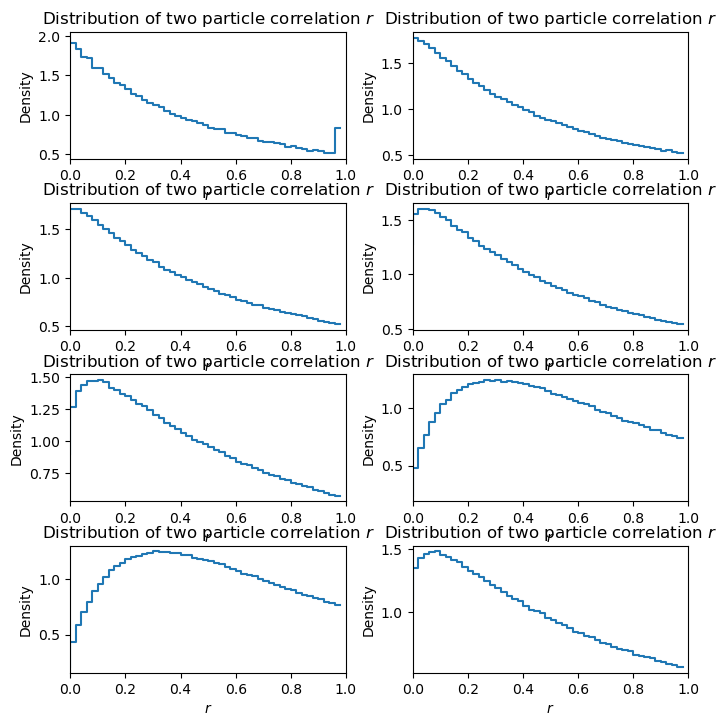

In [7]:
W = 2
t = 1
### Exact
n, e = 10, 5
K_l = [0, 0.01, 0.02, 0.05, 0.1, 0.5, 1, 10]
fig, ax = plt.subplots(4, 2, figsize=(7,7))
plt.tight_layout()
for i, axis in enumerate(ax.flatten()):
	sampler = BosonChainSampler(n, W, t, K=K_l[i], e=e, w0=100)
	matrixstats = MatrixStats(sampler)
	matrixstats.collect(n_realizations=1000, eigenvectors=False)
	rg = (matrixstats.d2correlations().min(), matrixstats.d2correlations().max())
	exact_hist, exact_edges = np.histogram(matrixstats.d2correlations(), bins=50, range=rg, density=True)

	axis.step(exact_edges[:-1], exact_hist, label="Exact", where="pre")
	axis.set_xlim(0, 1.)
	axis.set_xlabel(r"$r$")
	axis.set_ylabel(r"Density")
	axis.set_title("Distribution of two particle correlation $r$")

### Extremely strong perturbation

The perturbation strength is here set to a very high value. This way, the states containing multiple excitations are energetically unfavourable and the system should behave more like a spin lattice. In particular, the eigenvalues are clumped in $f(e)$ clusters, where $e$ represents the number of excitations in the system, depending on the number of multiply-excited states in the cluster.

In [202]:
K = 100
W = 0.5
t = 1
### Exact
n, e = 10, 5
sampler = BosonChainSampler(n, W, t, K=K, e=e, w0=100)
matrixstats = MatrixStats(sampler)
matrixstats.collect(n_realizations=1000, eigenvectors=False)

### Perturbative
sampler = BosonChainSampler(n, W, t, e=1, w0=100)
study = ManyBodyLevels(e, K)
sstats = MatrixStats(sampler)
sstats.collect(n_realizations=1000, eigenvectors=True)
manybody = study(sstats)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 2002/2002 [00:10<00:00, 189.39it/s]


Area error: 21.0%


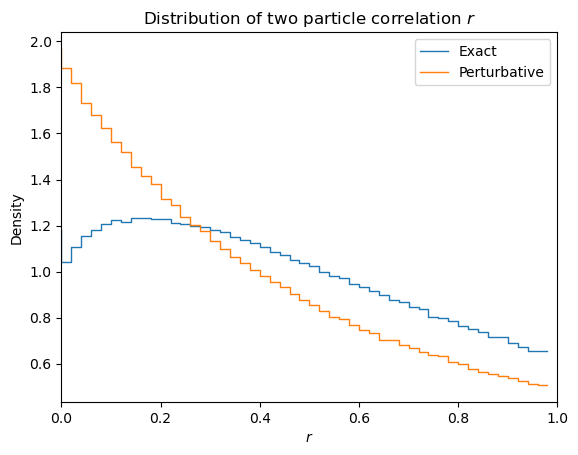

In [203]:
rg = (matrixstats.d2correlations().min(), matrixstats.d2correlations().max())
exact_hist, exact_edges = np.histogram(matrixstats.d2correlations(), bins=50, range=rg, density=True)
pert_hist, pert_edges = np.histogram(manybody.d2correlations(), bins=50, range=rg, density=True)
plt.step(exact_edges[:-1], exact_hist, label="Exact", where="pre")
plt.step(pert_edges[:-1], pert_hist, label="Perturbative", where="pre")
plt.xlim(0, 1.)
plt.legend()
plt.xlabel(r"$r$")
plt.ylabel(r"Density")
plt.title("Distribution of two particle correlation $r$")
error_percentage = np.sum(np.abs(exact_hist - pert_hist) * (exact_edges[1] - exact_edges[0]))
print(f"Area error: {error_percentage:.1%}")

Is this system Anderson localized?

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:18<00:00, 537.96it/s]


Text(0.5, 1.0, 'Distribution of spacings')

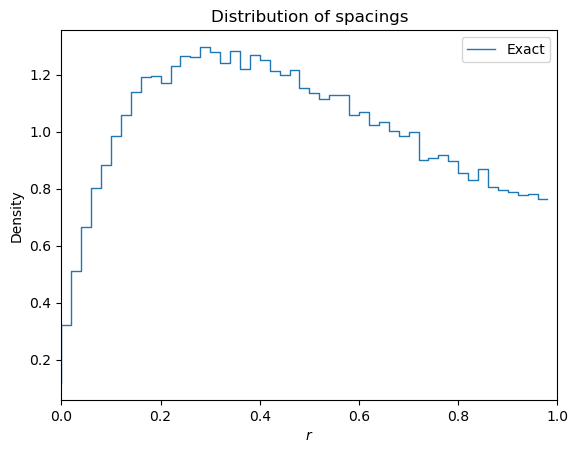

In [183]:
K = 100
W = 0.5
t = 1
### Exact
n, e = 10, 1
ssampler = BosonChainSampler(n, W, t, K=K, e=e, w0=100)
smatrixstats = MatrixStats(sampler)
smatrixstats.collect(n_realizations=10000, eigenvectors=False)
rg = (0, 1)
exact_hist, exact_edges = np.histogram(smatrixstats.d2correlations(), bins=50, range=rg, density=True)
plt.step(exact_edges[:-1], exact_hist, label="Exact", where="pre")
plt.xlim(rg[0], rg[1])
plt.legend()
plt.xlabel(r"$r$")
plt.ylabel(r"Density")
plt.title("Distribution of spacings")

#### Clustering of eigenvalues

This histogram represents how the eigenvalues are clustered. For $e=5$, the clusters represent the following states (energy increase in units of K)

| Cluster n | energy increase (in K) | 1-excited modes | 2-excited modes | 3-excited modes | 4-excited modes | 5-excited modes |
|---|------------------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| 0 | 0                      | 5               | 0               | 0               | 0               | 0               |
| 1 | 2                      | 3               | 1               | 0               | 0               | 0               |
| 2 | 4                      | 1               | 2               | 0               | 0               | 0               |
| 3 | 6                      | 2               | 0               | 1               | 0               | 0               |
| 4 | 8                      | 0               | 1               | 1               | 0               | 0               |
| 5 | 12                     | 1               | 0               | 0               | 1               | 0               |
| 6 | 20                     | 0               | 0               | 0               | 0               | 1               |

Text(0.5, 1.0, 'Clustering of eigenvalues for $e=5$')

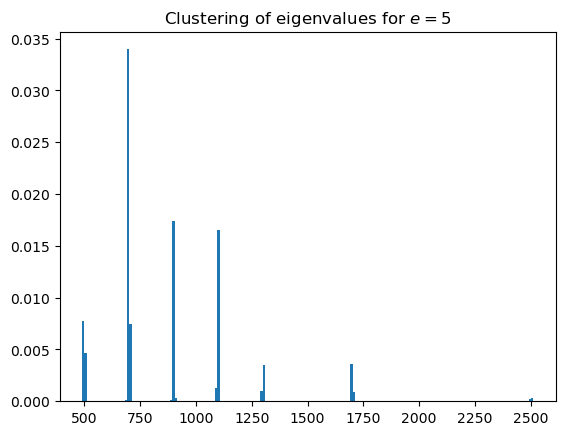

In [204]:
_ = plt.hist(matrixstats.eigenvalues().flatten(), bins=200, density=True)
plt.title("Clustering of eigenvalues for $e=5$")

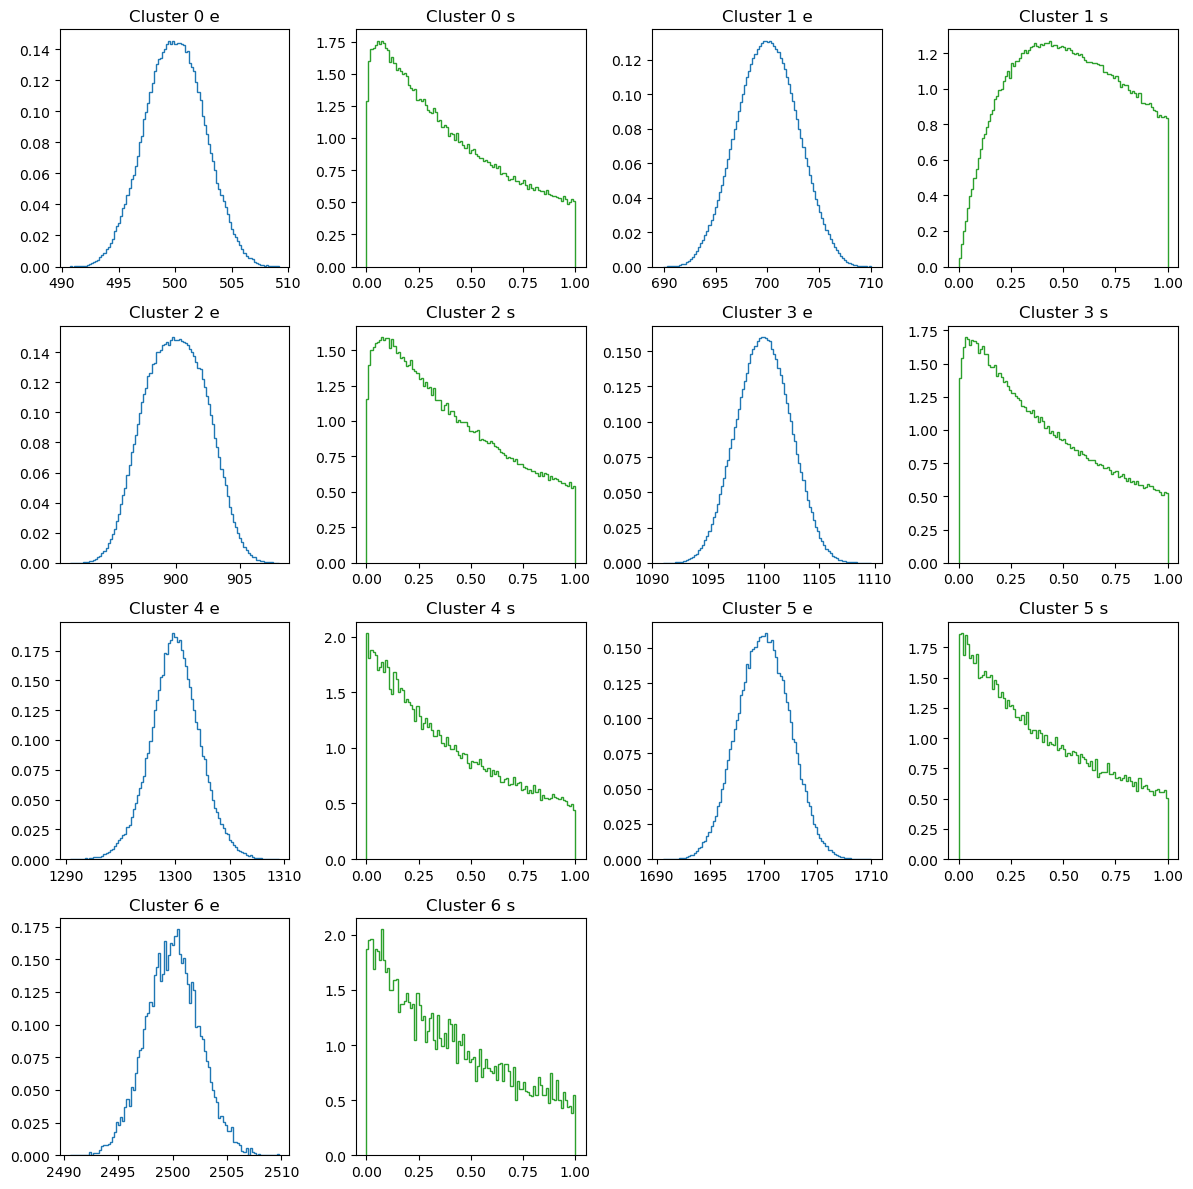

In [205]:
splits = (0, 600, 800, 1000, 1250, 1500, 2000, 3000)
fig = plt.figure(figsize=(12, 12))
gs = fig.add_gridspec(4, 4)
for cluster in range(len(splits)-1):
	eig_axis = fig.add_subplot(gs[2*cluster + 0])
	s_axis = fig.add_subplot(gs[2*cluster + 1])
	rng = (splits[cluster], splits[cluster+1])
	ev = [ev_i[np.logical_and(ev_i > rng[0], ev_i < rng[1])] for ev_i in matrixstats.eigenvalues()]
	# warning: this assumes the clusters are well separated
	# and the cardinality of the selected cluster in each sample is the same.
	ev = np.array(ev)
	delta = np.diff(ev, axis=1)
	dn, dnm1 = delta[:, :-1], delta[:, 1:]
	r = np.minimum(dn, dnm1) / np.maximum(dn, dnm1)
	rng = (ev.min(), ev.max())
	_ = eig_axis.hist(ev.flatten(), bins=100, density=True, histtype="step", range = rng)
	_ = s_axis.hist(r.flatten(), bins=100, range=(0,1), density=True, histtype="step", color="C2")
	eig_axis.set_title(f"Cluster {cluster} e")
	s_axis.set_title(f"Cluster {cluster} s")
fig.tight_layout()
# fig.savefig("test_perturbation_res/clustered_e_s_K100.png")

#### Reason for the small amount of level repulsion in the r histogram

The states in cluster 1 have level repulsion. Indeed, the Hamiltonian matrix in the basis of cluster-1 states has diagonal random elements (distributed as a gaussian with $W=\sqrt{2}$) and hopping terms between neighbour 2-excitations (of strength $2t$), while the perturbation becomes an irrelevant constant. This is the same matrix as the one for a spin lattice, which for these values of disorder and hopping is localized. This is seen in the second pair of plots above.

When the perturbation is absent, the eigenvalues for the different clusters overlap, but when some perturbation is able to separate the eigenvalues of $\mathcal{C}_1$ from the other ones, the spacings distribution shows some of the level repulsion from this cluster of states.